In [1]:
import re
import math
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [52]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
    #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
    text = re.sub("[\_àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",'', text)
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [53]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [54]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [55]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 17)
(996, 17)


In [56]:
df['diff_word'] = abs(df['word_count_question'] - df['word_count_lookup'])
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df['diff_bin'] = pd.cut(df['diff_word'], bins=my_bins, labels=my_labels)
df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

In [57]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [58]:
tf_pos = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1200)
tfidf_matrix_pos = tf_pos.fit_transform(df_pos['clean_question'])
tfidf_matrix_pos = pd.DataFrame(tfidf_matrix_pos.toarray(),
                                columns = tf_pos.get_feature_names())
tfidf_matrix_pos.shape

(996, 1200)

In [21]:
# PC_values = np.arange(pca.n_components_) + 1
# sb.set_theme()
# plt.figure(figsize=(10, 6))
# plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.show()

In [22]:
t0 = time()
var = 0.0
a = list(range(0, 2600, 100))
for k in a:
    pca = PCA(k, svd_solver = 'full')
    pca.fit(tfidf_matrix_pos)
    
    cur_var = pca.explained_variance_ratio_.sum() * 100
    increase = cur_var - var
    print("* k = {} --> cumulative variance: {:.2f}% --> increase: {:.2f}%".format(k, cur_var, increase))
    var = cur_var
    
print('Finding optimal k by PCA took {:.2f}s.'.format((time() - t0) / 60))

* k = 0 --> cumulative variance: 0.00% --> increase: 0.00%
* k = 100 --> cumulative variance: 63.15% --> increase: 63.15%
* k = 200 --> cumulative variance: 80.22% --> increase: 17.07%
* k = 300 --> cumulative variance: 89.48% --> increase: 9.26%
* k = 400 --> cumulative variance: 94.85% --> increase: 5.38%
* k = 500 --> cumulative variance: 97.81% --> increase: 2.96%
* k = 600 --> cumulative variance: 99.27% --> increase: 1.46%
* k = 700 --> cumulative variance: 99.85% --> increase: 0.58%
* k = 800 --> cumulative variance: 99.99% --> increase: 0.14%
* k = 900 --> cumulative variance: 100.00% --> increase: 0.01%


ValueError: n_components=1000 must be between 0 and min(n_samples, n_features)=996 with svd_solver='full'

In [10]:
t0 = time()
var = 0.0
a = list(range(1, 2600, 100))
for k in a:
    pca = PCA(k, svd_solver = 'randomized')
    pca.fit(tfidf_matrix_pos)
    
    cur_var = pca.explained_variance_ratio_.sum() * 100
    increase = cur_var - var
    print("* k = {} --> cumulative variance: {:.2f}% --> increase: {:.2f}%".format(k, cur_var, increase))
    var = cur_var
    
print('Finding optimal k by PCA took {:.2f}s.'.format((time() - t0) / 60))

* k = 1 --> cumulative variance: 4.98% --> increase: 4.98%
* k = 101 --> cumulative variance: 63.46% --> increase: 58.48%
* k = 201 --> cumulative variance: 80.50% --> increase: 17.04%
* k = 301 --> cumulative variance: 89.80% --> increase: 9.30%
* k = 401 --> cumulative variance: 95.13% --> increase: 5.33%
* k = 501 --> cumulative variance: 98.01% --> increase: 2.87%
* k = 601 --> cumulative variance: 99.37% --> increase: 1.37%
* k = 701 --> cumulative variance: 99.88% --> increase: 0.51%
* k = 801 --> cumulative variance: 100.00% --> increase: 0.11%
* k = 901 --> cumulative variance: 100.00% --> increase: 0.00%


ValueError: n_components=1001 must be between 1 and min(n_samples, n_features)=996 with svd_solver='randomized'

In [59]:
pca = PCA(n_components = 600, random_state=42)
question_pca = pca.fit_transform(tfidf_matrix_pos)

Sum of variance: 0.9938304709330895



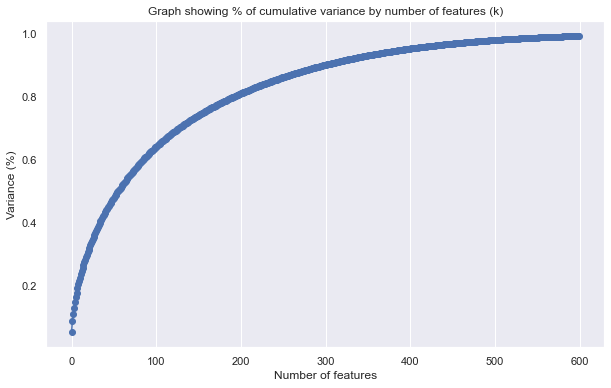

In [60]:
print('Sum of variance: {}'.format(pca.explained_variance_ratio_.sum()))
print()
sb.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
plt.xlabel("Number of features")
plt.ylabel("Variance (%)")
plt.title("Graph showing % of cumulative variance by number of features (k)")
# plt.xlim([0, tfidf_matrix.shape[1] - 1])
plt.grid(axis = "y")
plt.show()

In [34]:
def cosine_search_all(queries, tf, pca_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 
                                      'cosine_word_count_question', 'cosine_diff_bin', 'cosine_image'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        query_pca = pca.transform(query_tf)
        cosine_sim = cosine_similarity(query_pca, pca_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['Question Text'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values,
                               'cosine_diff_bin': data.iloc[related_index, :]['diff_bin'].values,
                               'cosine_image': data.iloc[related_index, :]['Question Image'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    times = time() - t0
    if check_time:
        if times < 60:
            print('Cosine search took {:.2f}s.'.format(times))
        else:
            print('Cosine search took {:.2f} minutes.'.format(times / 60))
    return results

In [61]:
result_pos = cosine_search_all(df_pos['Lookup Text'], tf_pos, question_pca, df_pos)

Cosine search took 22.74s.


In [62]:
df_pos['search_result'] = result_pos['question_text']
df_pos['score'] = result_pos['sim_score']
df_pos['cosine_word_count_question'] = result_pos['cosine_word_count_question']
df_pos['cosine_diff_bin'] = result_pos['cosine_diff_bin']
df_pos['cosine_image'] = result_pos['cosine_image']

In [63]:
mask5 = df_pos['Question Text'] != df_pos['search_result']

df_check_pos = df_pos[mask5]
df_check_pos.shape

(62, 24)

In [64]:
def cosine_pos(query, tf, pca_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    query_pca = pca.transform(query_tf)
    cosine_sim = cosine_similarity(query_pca, pca_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': data.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [65]:
def check_wrong_results(indices):
    index_ = df_check_pos.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_pos(df_check_pos.iloc[num]['Lookup Text'], tf_pos, question_pca, df_pos, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_pos.iloc[num]['Lookup Text'] in top_results) or (df_check_pos.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

top5_result_pos, no_result_pos = check_wrong_results(list(range(0, len(df_check_pos.index))))

In [66]:
print(len(top5_result_pos))
print(len(no_result_pos))

44
18


In [67]:
mask6 = df_pos['Question Text'] == df_pos['search_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(934, 24)

In [68]:
df_top5_pos = df_pos.iloc[top5_result_pos, :]
df_top5_pos.shape

(44, 24)

In [69]:
df_no_pos = df_pos.iloc[no_result_pos, :]
df_no_pos.shape

(18, 24)

In [70]:
df_no_pos = df_no_pos.sort_values(by = 'score', ascending = False)

PAIRS: 1 - Cosine score: 1.0000000000000002
-- Number of words: 26


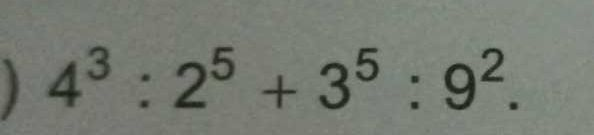

-- Number of words: 28


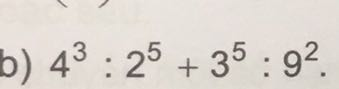

-- Number of words: 34


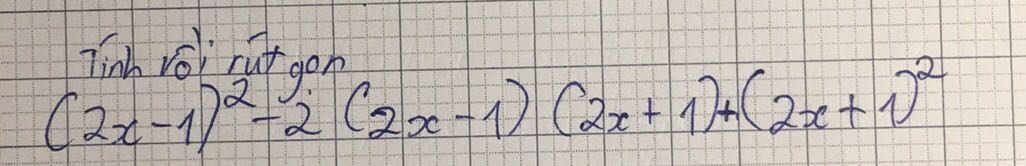

************
PAIRS: 2 - Cosine score: 1.0000000000000002
-- Number of words: 20


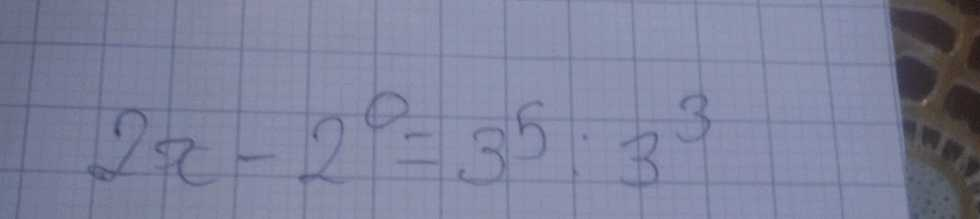

-- Number of words: 22


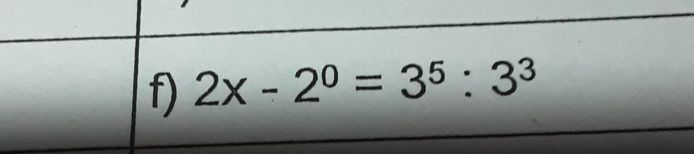

-- Number of words: 34


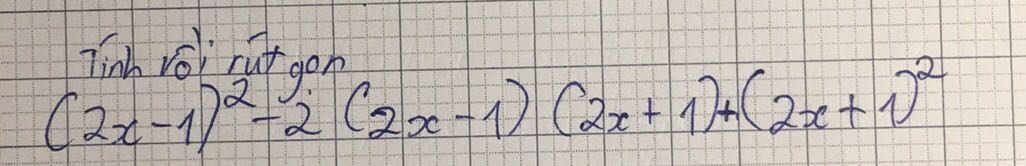

************
PAIRS: 3 - Cosine score: 0.9769436513531856
-- Number of words: 54


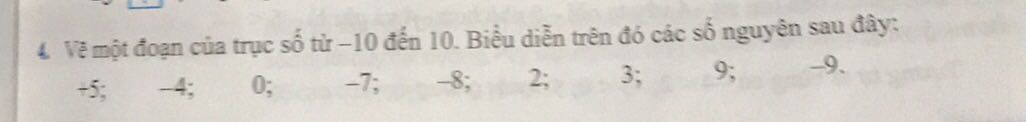

-- Number of words: 68


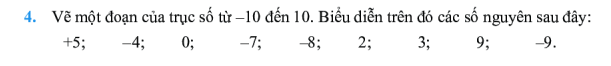

-- Number of words: 55


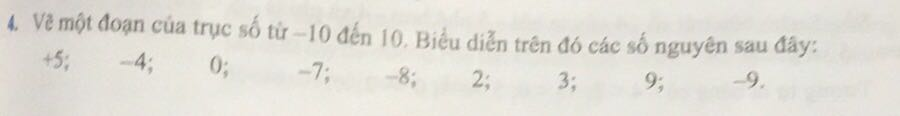

************
PAIRS: 4 - Cosine score: 0.9618489343541232
-- Number of words: 28


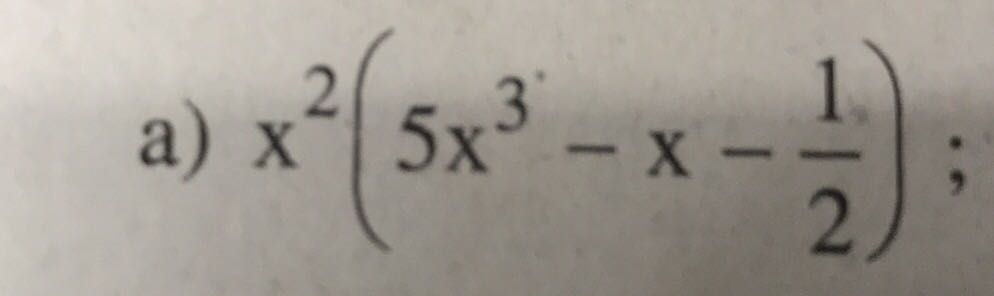

-- Number of words: 32


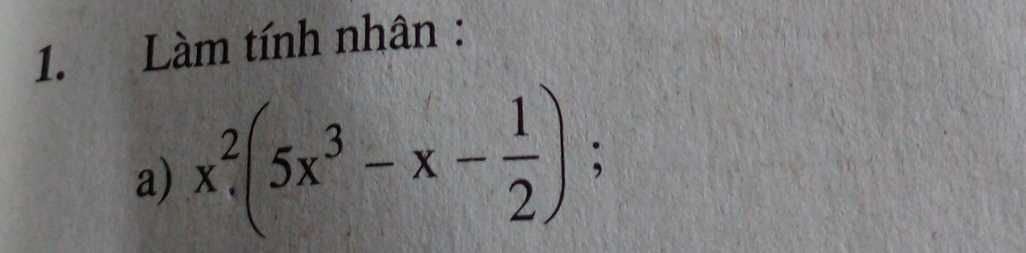

-- Number of words: 141


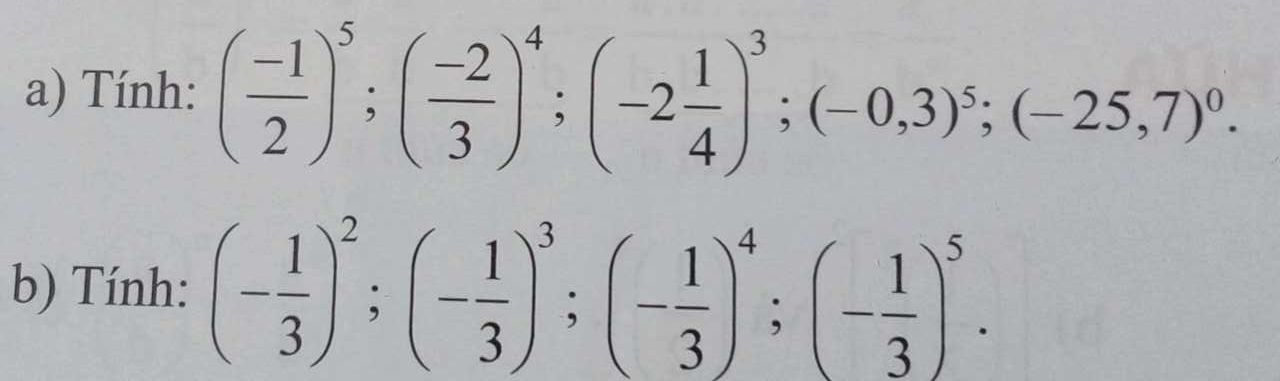

************
PAIRS: 5 - Cosine score: 0.9310999452238102
-- Number of words: 31


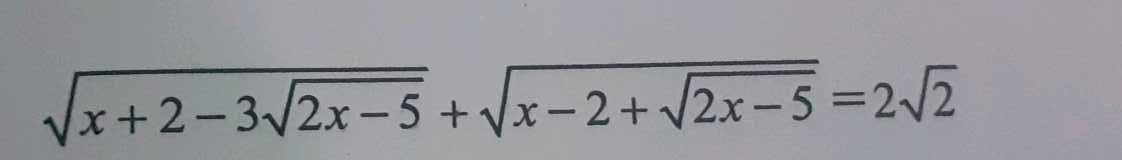

-- Number of words: 33


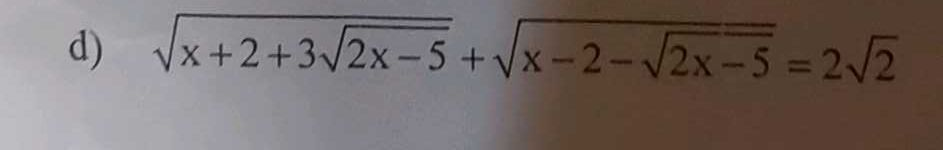

-- Number of words: 72


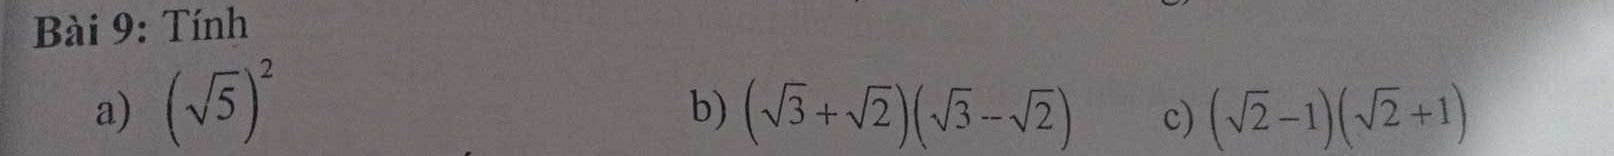

************
PAIRS: 6 - Cosine score: 0.9268490507408573
-- Number of words: 32


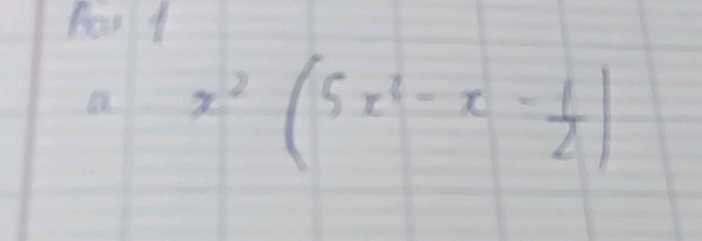

-- Number of words: 32


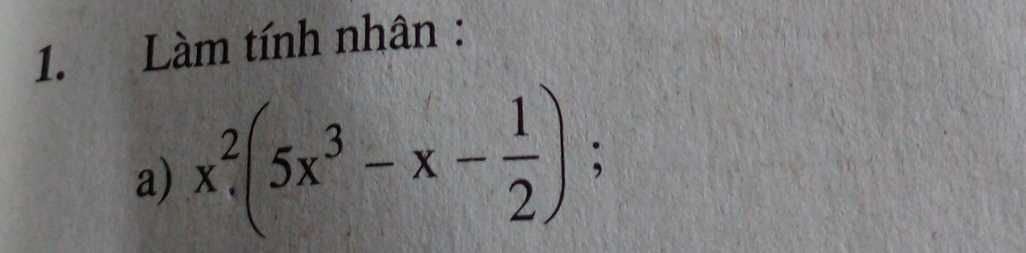

-- Number of words: 141


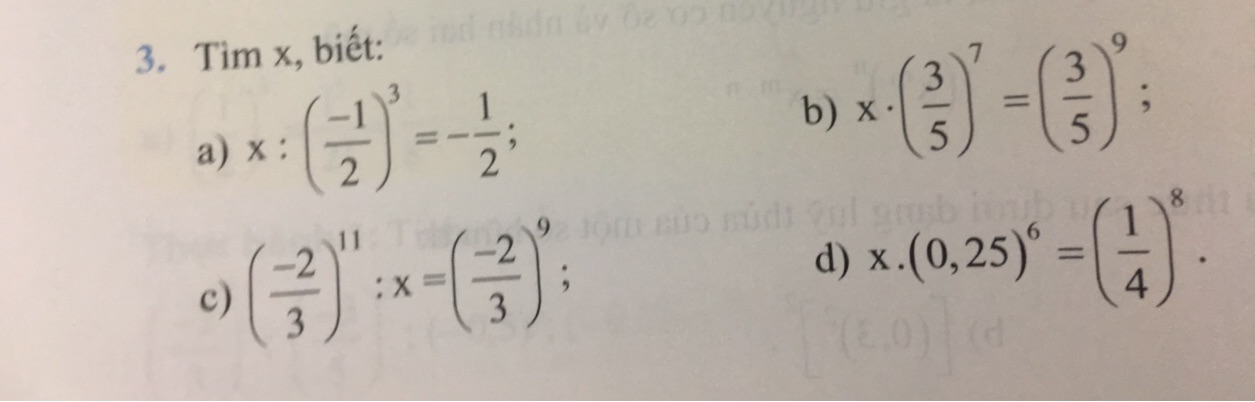

************
PAIRS: 7 - Cosine score: 0.9003778742775117
-- Number of words: 50


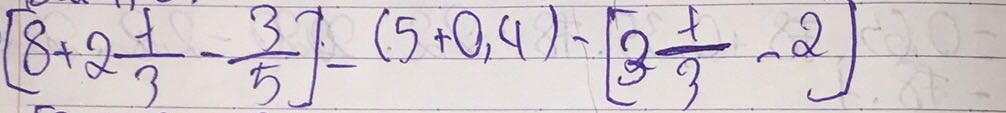

-- Number of words: 49


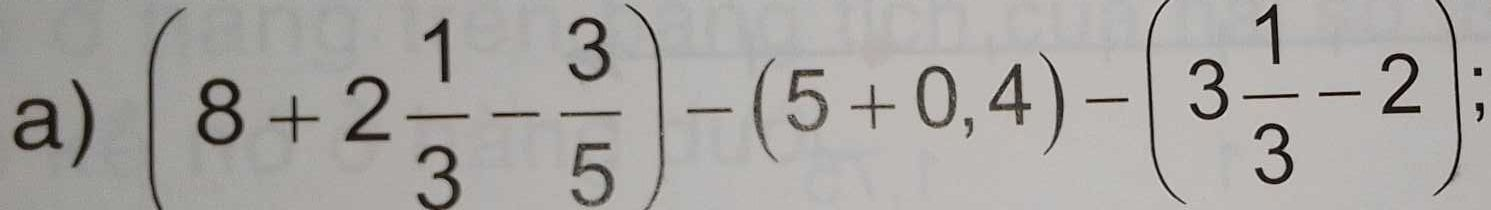

-- Number of words: 326


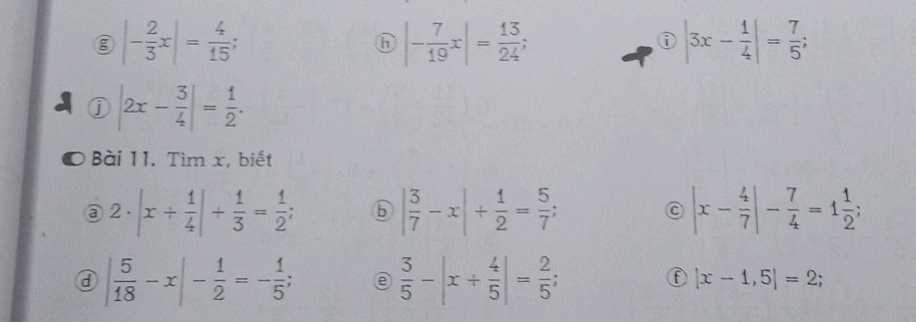

************
PAIRS: 8 - Cosine score: 0.8869119348950465
-- Number of words: 57


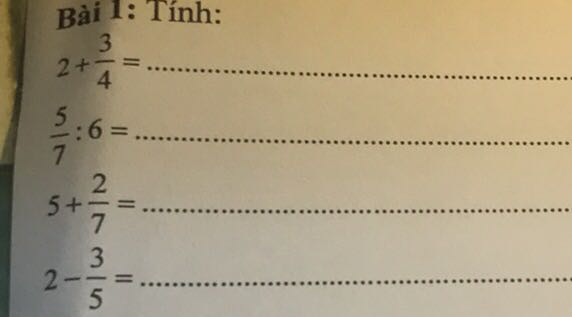

-- Number of words: 75


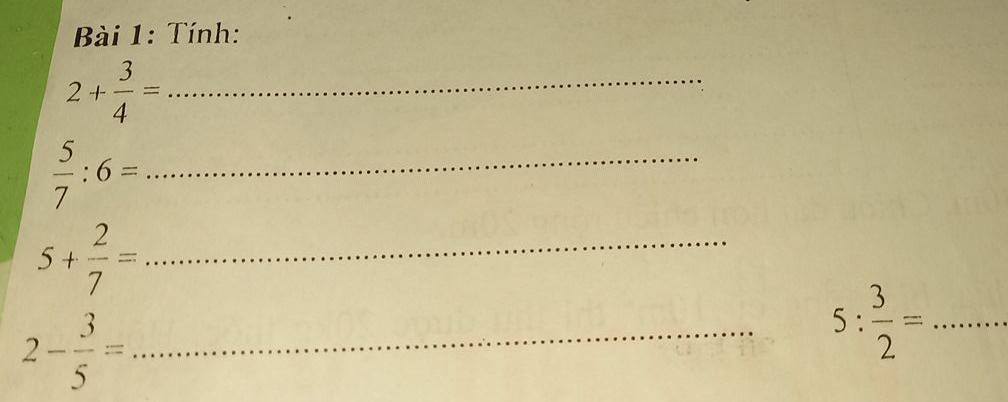

-- Number of words: 19


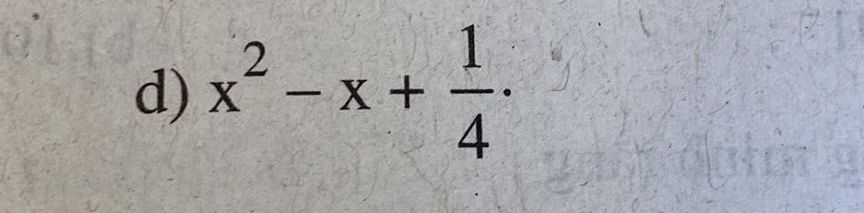

************
PAIRS: 9 - Cosine score: 0.8368900107966366
-- Number of words: 36


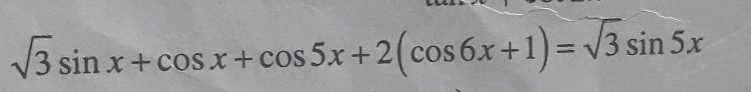

-- Number of words: 43


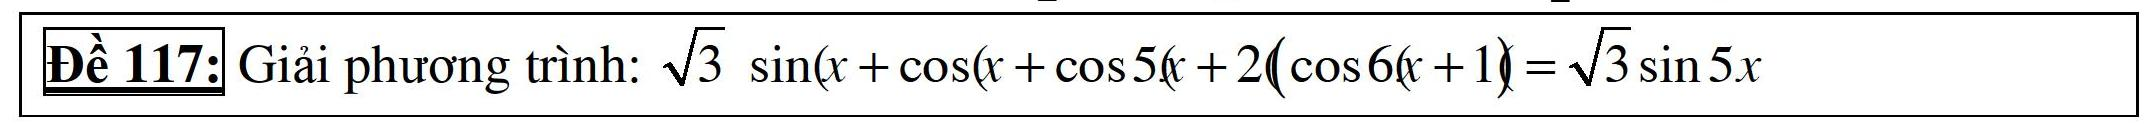

-- Number of words: 28


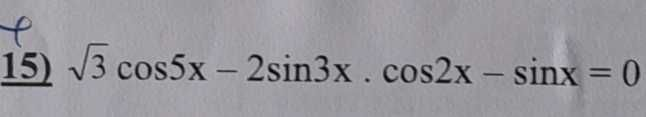

************
PAIRS: 10 - Cosine score: 0.7907564299233727
-- Number of words: 16


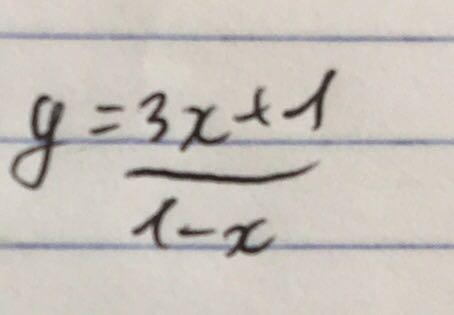

-- Number of words: 30


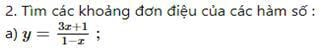

-- Number of words: 89


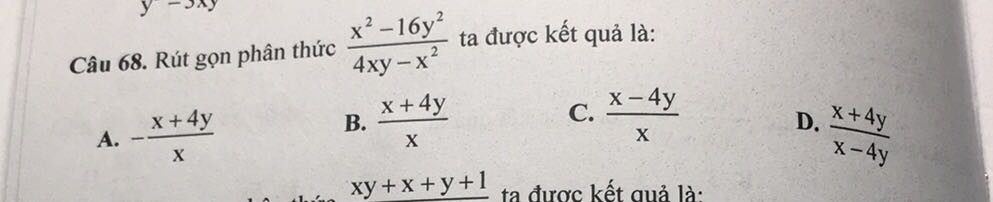

************
PAIRS: 11 - Cosine score: 0.6136100486798732
-- Number of words: 33


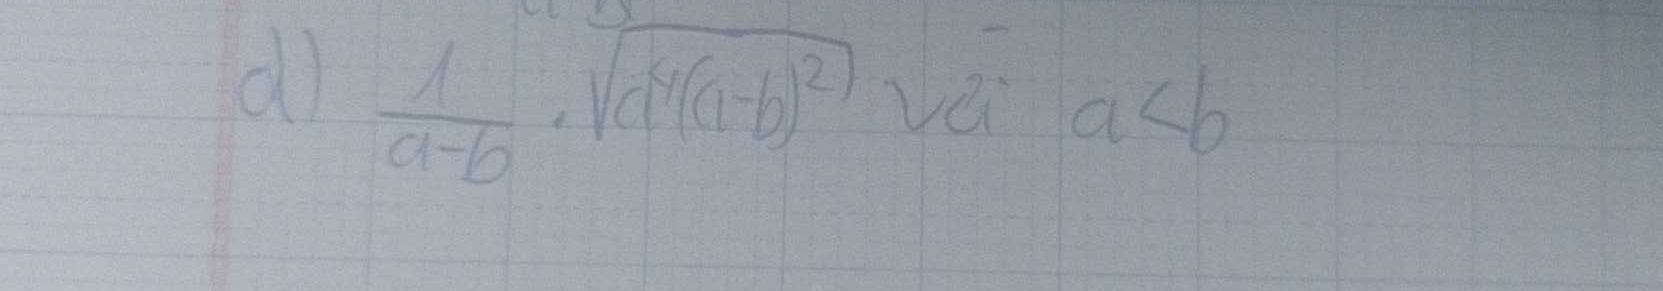

-- Number of words: 35


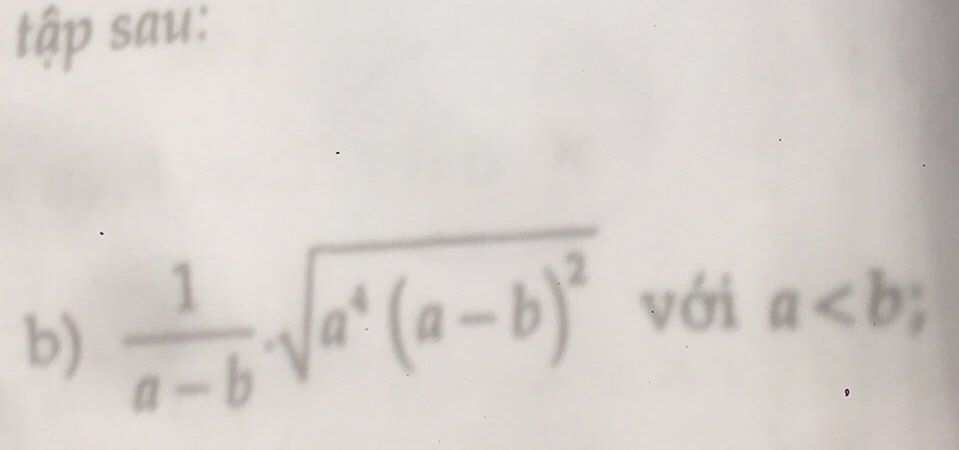

-- Number of words: 24


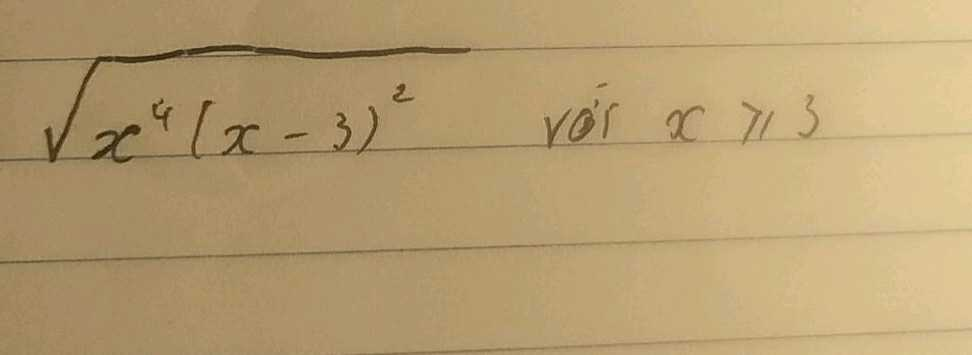

************
PAIRS: 12 - Cosine score: 0.6108416793912014
-- Number of words: 72


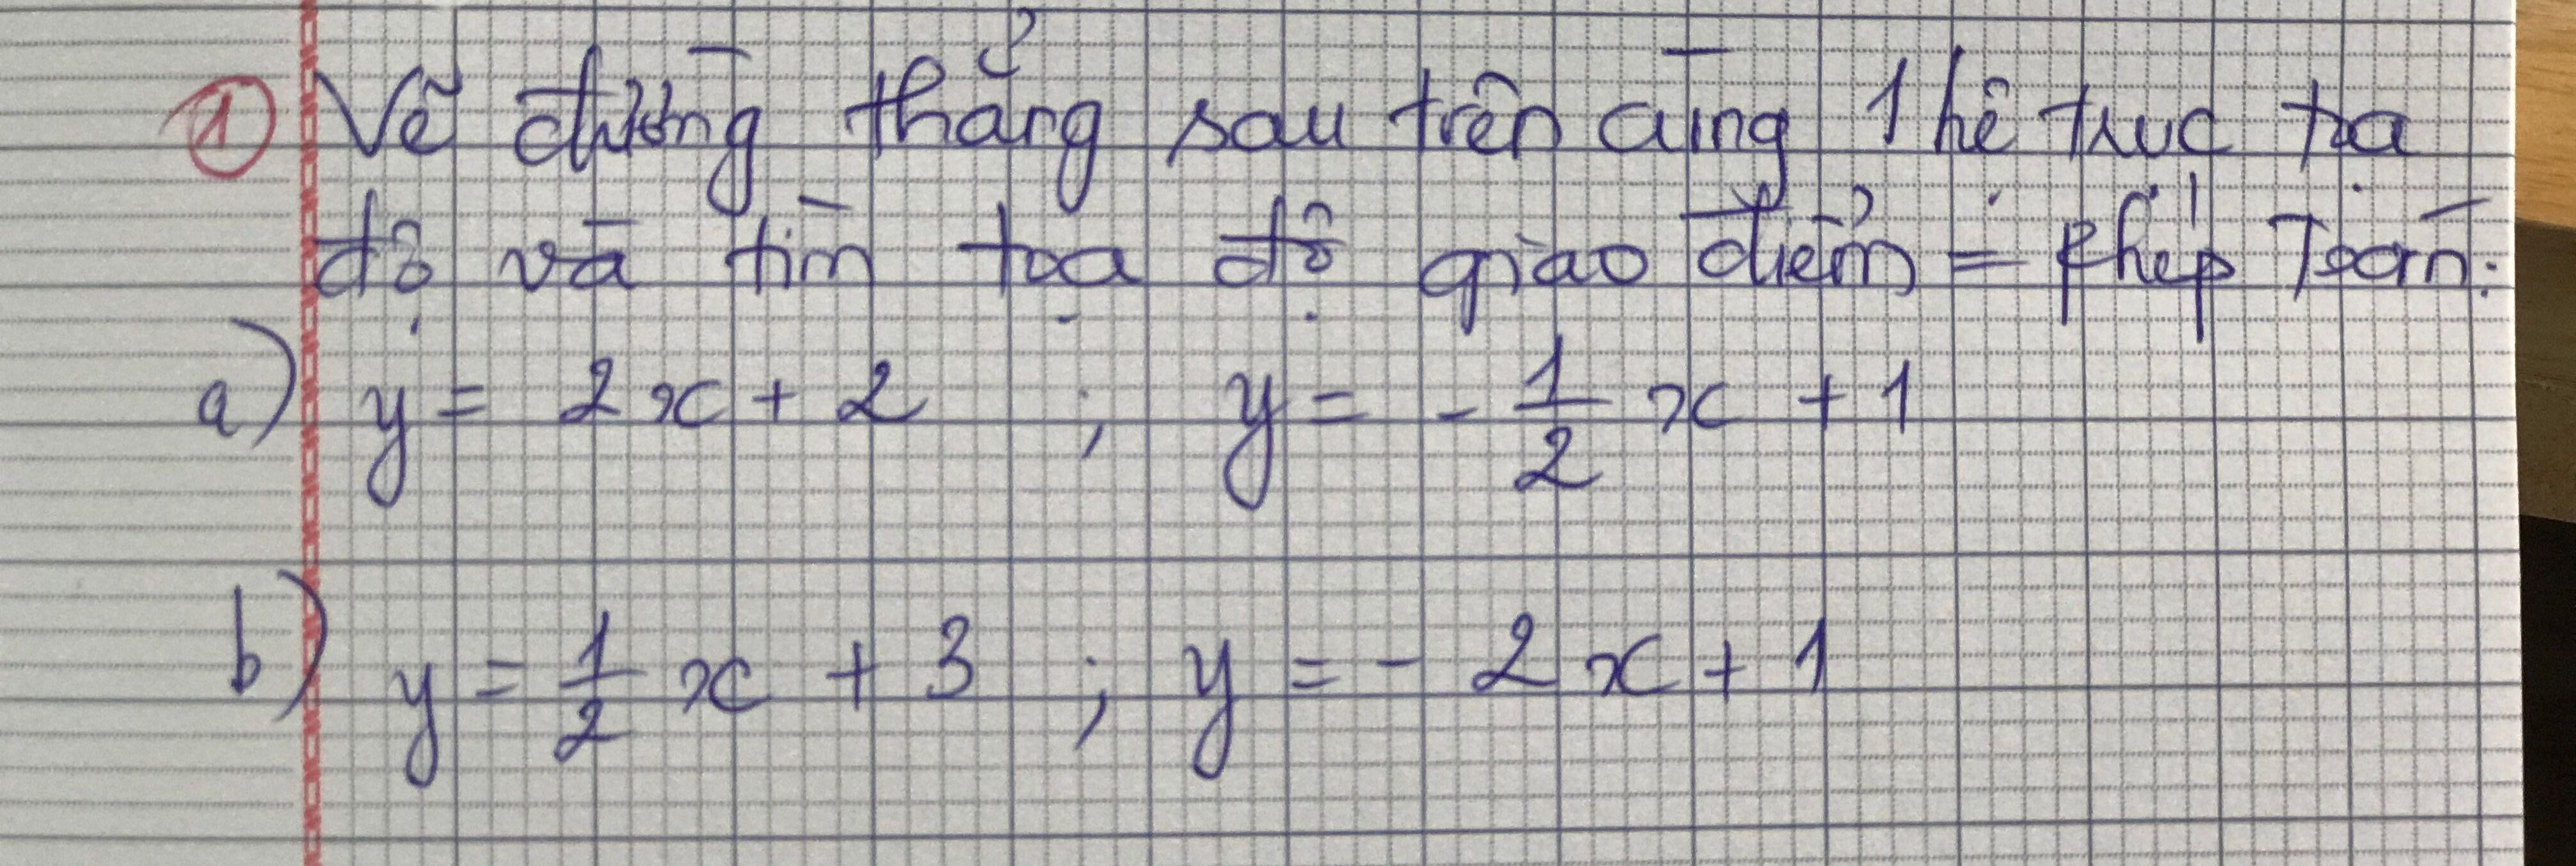

-- Number of words: 90


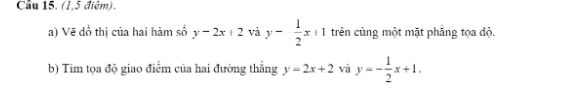

-- Number of words: 118


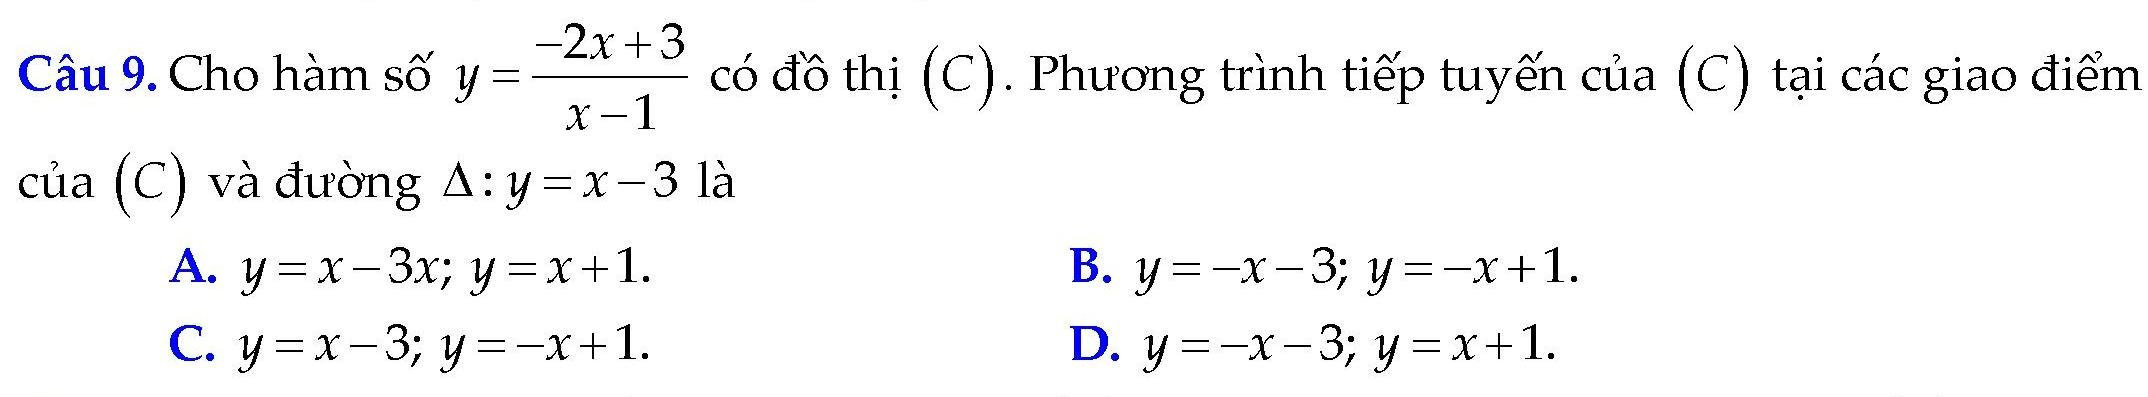

************
PAIRS: 13 - Cosine score: 0.5915702057641238
-- Number of words: 45


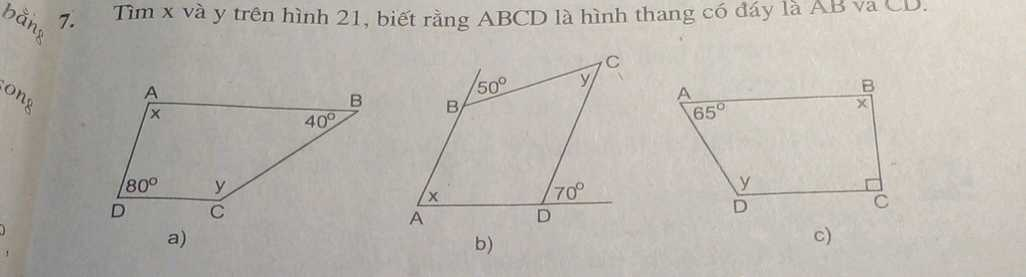

-- Number of words: 40


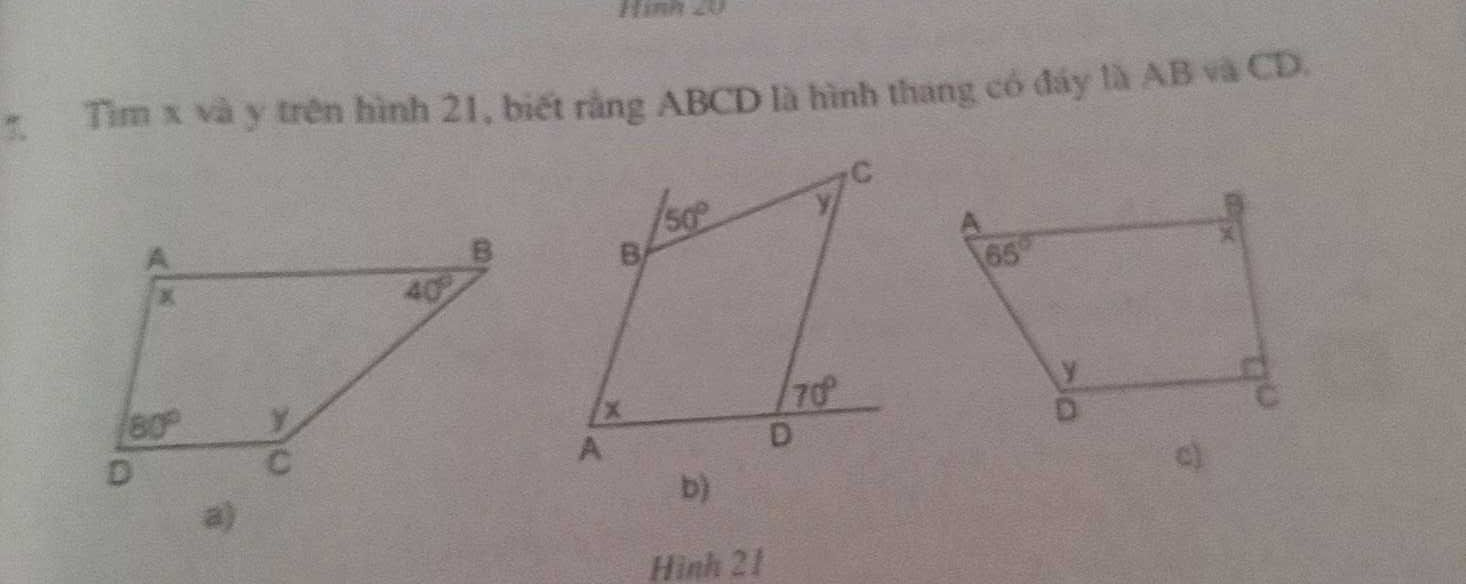

-- Number of words: 86


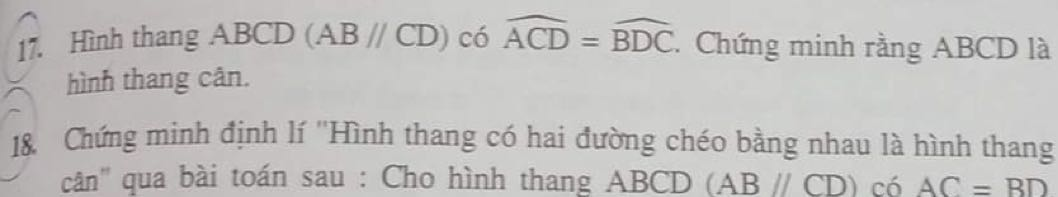

************
PAIRS: 14 - Cosine score: 0.5474689513318446
-- Number of words: 12


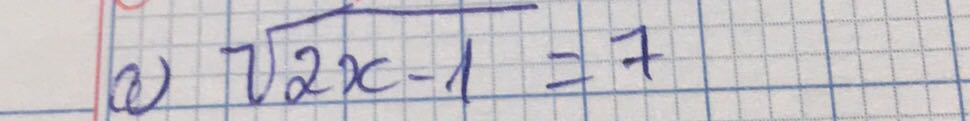

-- Number of words: 46


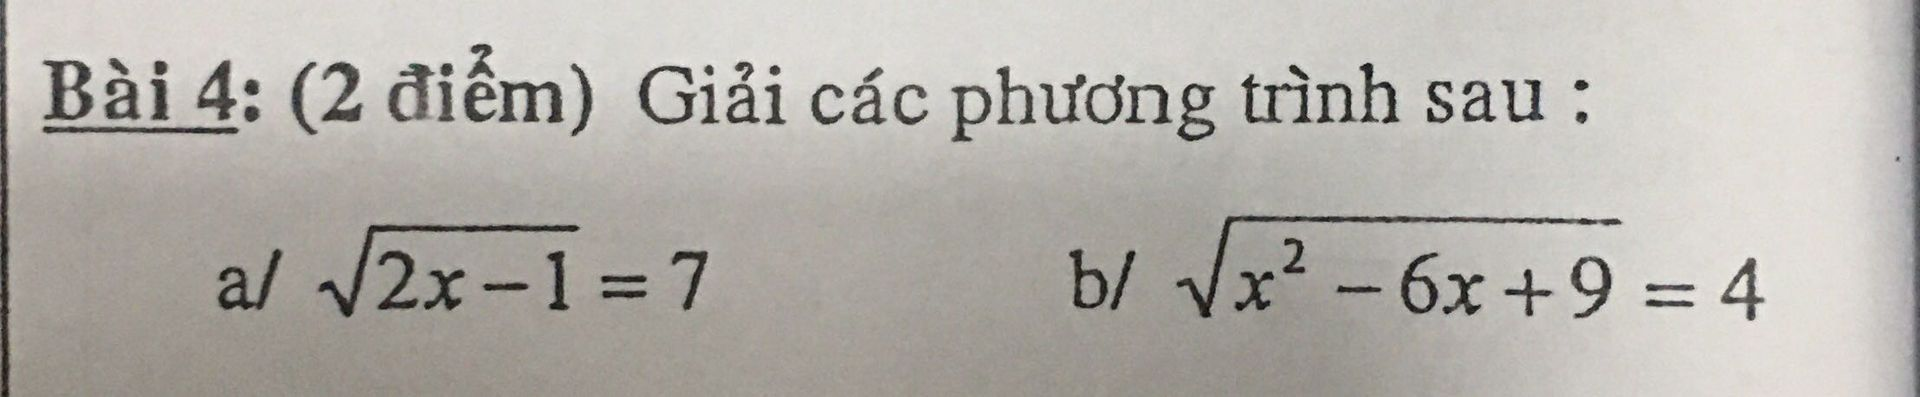

-- Number of words: 13


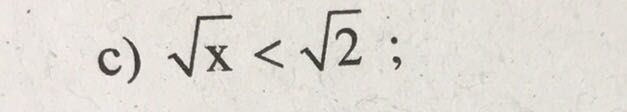

************
PAIRS: 15 - Cosine score: 0.5092195941015272
-- Number of words: 78


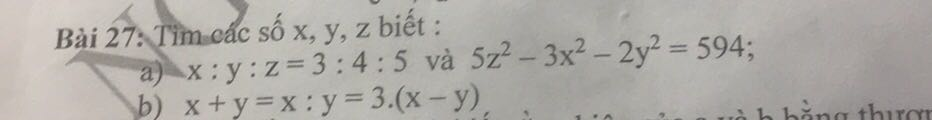

-- Number of words: 79


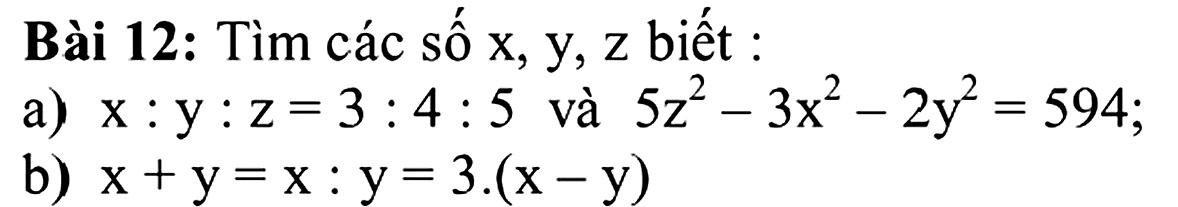

-- Number of words: 16


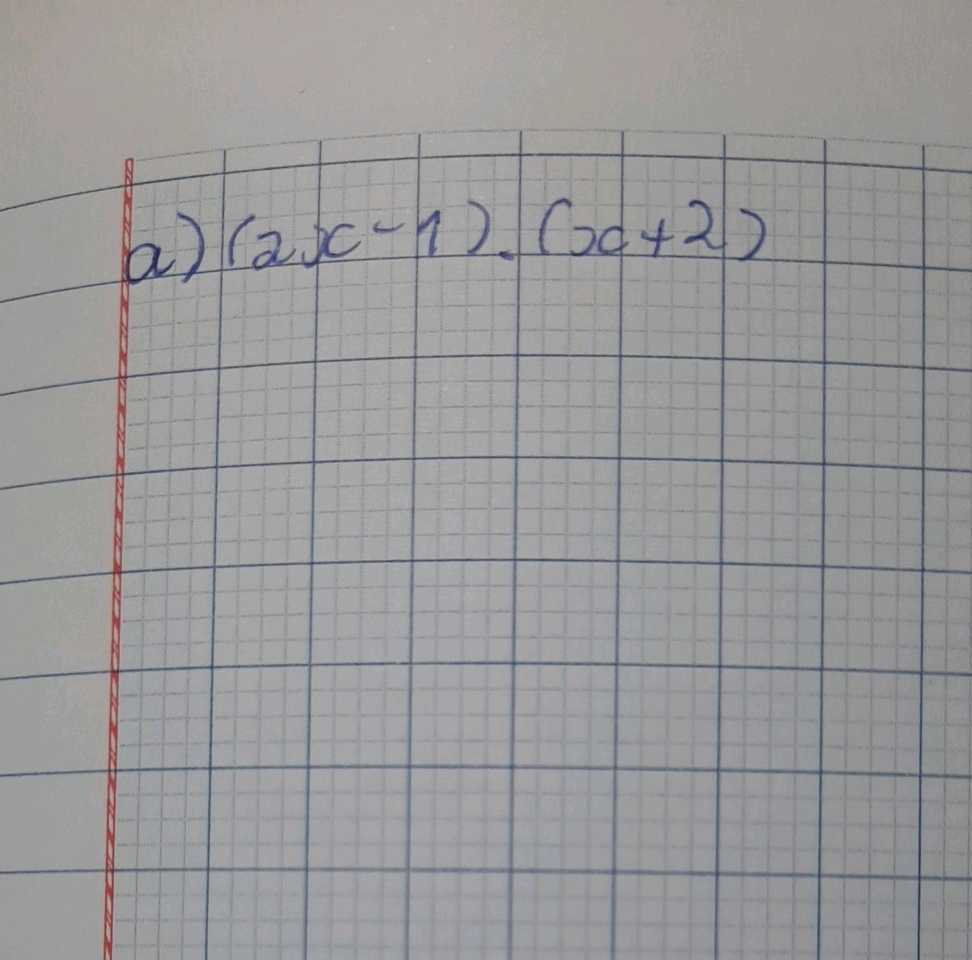

************
PAIRS: 16 - Cosine score: 0.44807701518223897
-- Number of words: 100


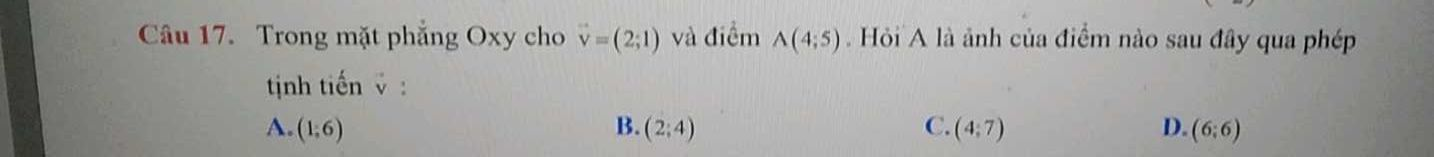

-- Number of words: 104


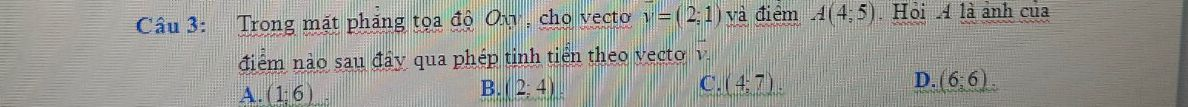

-- Number of words: 64


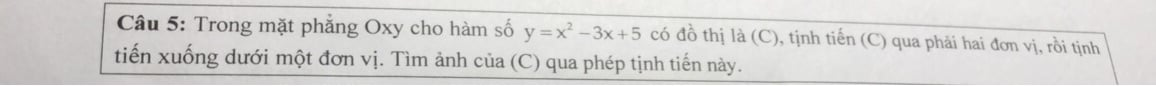

************
PAIRS: 17 - Cosine score: 0.31246915672598585
-- Number of words: 19


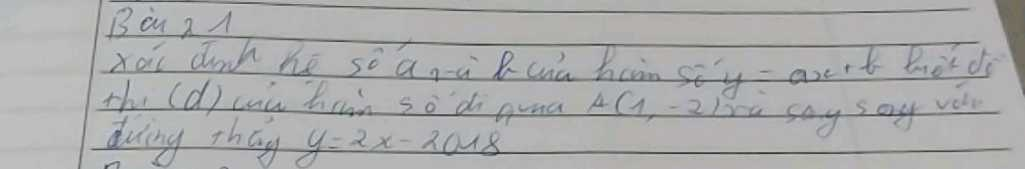

-- Number of words: 66


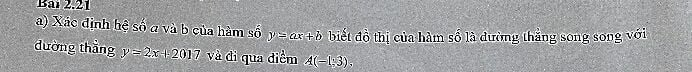

-- Number of words: 36


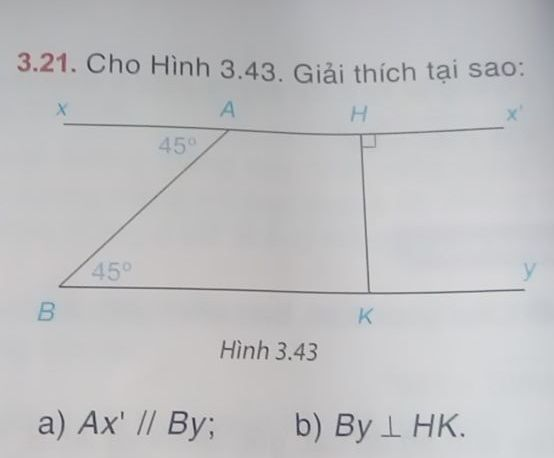

************
PAIRS: 18 - Cosine score: 0.2384824120779696
-- Number of words: 62


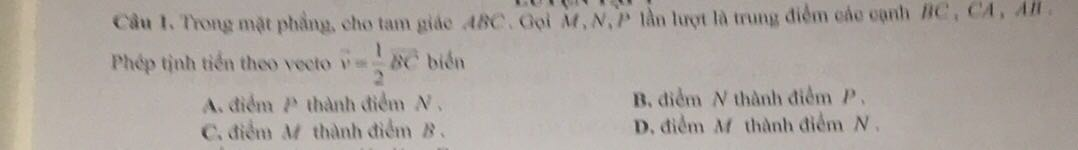

-- Number of words: 121


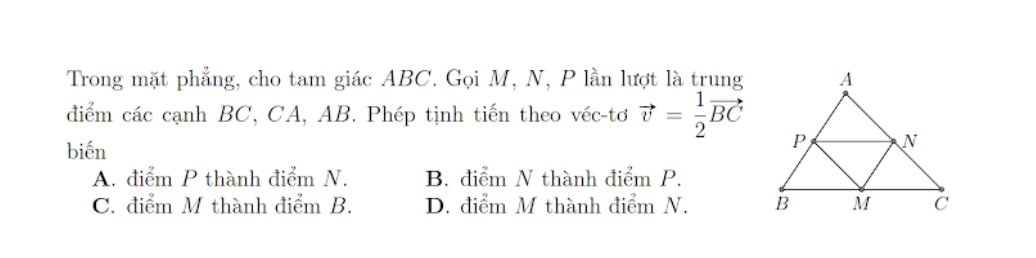

-- Number of words: 111


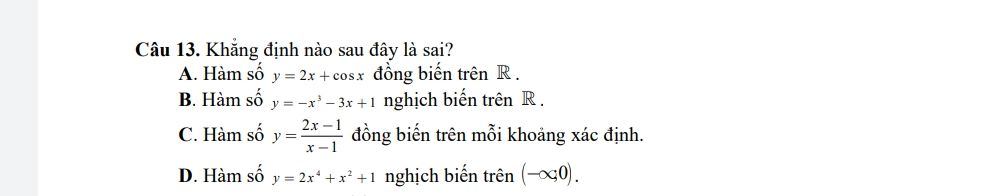

************


In [71]:
idx = 0
for url1, url2 in zip(df_no_pos['Question Image'].values, df_no_pos['cosine_image'].values):
    print('PAIRS: {} - Cosine score: {}'.format(idx + 1, df_no_pos['score'].values[idx]))
    print('-- Number of words:', df_no_pos['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_no_pos['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_no_pos['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_no_pos['cosine_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    idx += 1